## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

In [1]:
#Importing Necessary Modules

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#Setting the seed to assure that we get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
print("The number of rows in dataset is", df.shape[0])

The number of rows in dataset is 294478


c. The number of unique users in the dataset.

In [4]:
print("The number of unique users in the dataset", df.user_id.nunique())

The number of unique users in the dataset 290584


d. The proportion of users converted.

In [5]:
print("Converted Users", (df.query('converted == 1')['user_id'].nunique()/df.user_id.count())*100)

Converted Users 11.94418598333322


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
print("The number of times the new_page and treatment don't line up",
      df.query('group=="treatment" and landing_page=="old_page"').user_id.nunique() +
            df.query('group=="control" and landing_page=="new_page"').user_id.nunique())

The number of times the new_page and treatment don't line up 3893


f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There are total 294478 records in the dataset, all the columns have that same number of records, hence no missing values. 

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#Let's keep a backup first
df2 = df.copy(deep=True)

df2.drop(df2.query('group=="treatment" and landing_page=="old_page"').index, inplace=True)
df2.drop(df2.query('group=="control" and landing_page=="new_page"').index, inplace=True)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
print("Number of unique user_ids", df.user_id.nunique())

Number of unique user_ids 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

The repeat user_id of 773192 belongs to the treatment group and was introduced to the new landing page after which he didn't convert as a new customer. 

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2.drop(df2[df2.user_id.duplicated()].index, inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [13]:
print("Probability of an individual converting regardless of the page they receive ->", 
          df2[df2['converted']==1].user_id.count() / df2.shape[0])

Probability of an individual converting regardless of the page they receive -> 0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
df2.head(1)

print("Given that an individual was in the control group, the probability they converted is ->", 
(df2.query('group=="control" and converted=="1"').user_id.count() / df2.shape[0]) /   \
      (df2.query('group=="control"').user_id.count() / df2.shape[0]))

Given that an individual was in the control group, the probability they converted is -> 0.12038630450046119


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
print("Given that an individual was in the control group, the probability they converted is ->", 
        (df2.query('group=="treatment" and converted=="1"').user_id.count() / df2.shape[0]) / 
              (df2.query('group=="treatment"').user_id.count() / df2.shape[0]))

Given that an individual was in the control group, the probability they converted is -> 0.11880806551510564


d. What is the probability that an individual received the new page?

In [16]:
df2.head()

print("Probability that an individual received the new page ->",
        df2[df2['landing_page'] == 'new_page'].user_id.count() / df2.shape[0])

Probability that an individual received the new page -> 0.5000619442226688


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Probability of individual converting given individual is in control group is 0.1203863045004612.**

**Probability of individual converting given individual is in treatment group is 0.11880724790277405.**

**It is evident that according to the current analysis, the difference between conversion probability between new and old page is not that significant to conclude that new treatment page led to more conversions. Further analysis is required.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} < = 0$$

$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [17]:
sample_new = df2['converted'].mean()
print("Convert rate", sample_new)

Convert rate 0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [18]:
sample_old = df2['converted'].mean()
print("Convert rate", sample_old)

Convert rate 0.11959708724499628


c. What is $n_{new}$?

In [19]:
n_new = len(df2[df2['landing_page'] == 'new_page'])
print(n_new)

145310


d. What is $n_{old}$?

In [20]:
n_old = len(df2[df2['landing_page'] == 'old_page'])
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
new_page_converted = np.random.choice([1, 0], size = n_new, replace=True, p = [sample_new, 1-sample_new])
print("Simulated Transactions", new_page_converted)

Simulated Transactions [0 0 0 ... 1 0 0]


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [22]:
old_page_converted = np.random.choice([1, 0], size = n_old, replace=True, p = [sample_old, 1-sample_old])
print("Simulated Transactions", old_page_converted)

Simulated Transactions [0 0 1 ... 1 0 0]


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [23]:
new_page_converted.mean() - old_page_converted.mean()

-0.0026795276101260063

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [24]:
p_diffs = []

#USing bootstrap sampling method

for _ in range(1, 10000): 
    old_page_converted = np.random.choice([1, 0], size = n_old, replace=True, p = [sample_old, 1-sample_old])
    new_page_converted = np.random.choice([1, 0], size = n_new, replace=True, p = [sample_new, 1-sample_new])
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

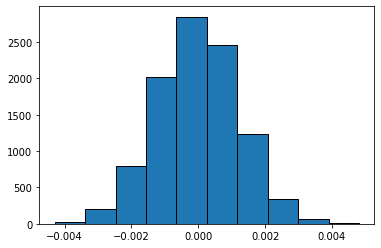

In [25]:
plt.hist(p_diffs, bins = 10, edgecolor='k')
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

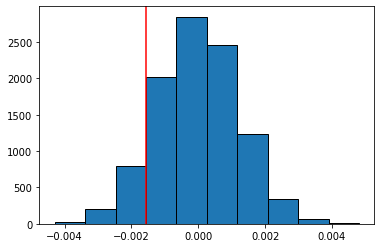

In [26]:
obs_diffs = (len(df2.query('landing_page=="new_page" and converted=="1"'))/n_new    
            - len(df2.query('landing_page=="old_page" and converted=="1"'))/n_old)


plt.hist(p_diffs, bins = 10, edgecolor='k')
plt.axvline(obs_diffs, c='red')
plt.show()

In [27]:
count = 0
for i in p_diffs: 
    if i > obs_diffs: 
        count += 1

print("Proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv\n")
print(count/len(p_diffs))

Proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv

0.8991899189918992


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value calculated is called the p-value. In a sentence, it is the evidence for rejecting the null hypothesis.**

**The smaller the p-value, the stronger the evidence that the null hypothesis should be rejected.**

**It is seen that almost 90% of the population in the sample is above the Observed difference which points to the fact that the new page is not doing significantly bettter than the old page. Since p-value is so large, we cannot reject the null hypothesis
and conclude that the old page is almost at par and probably slightly better than the new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

conv_old = len(df2.query('landing_page=="old_page" and converted=="1"'))
conv_new = len(df2.query('landing_page=="new_page" and converted=="1"'))
n_old = len(df2.query('landing_page=="old_page"'))
n_new = len(df2.query('landing_page=="new_page"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([conv_old, conv_new], [n_old, n_new], alternative='smaller')
print("The z-score and p-value are respectively ->", z_score, ',', p_value)

The z-score and p-value are respectively -> 1.3109241984234394 , 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [30]:
from scipy.stats import norm
print(norm.cdf(z_score), norm.ppf(1-(0.05)))

0.9050583127590245 1.6448536269514722


**The z-score of 0.905 is less than the critical value of 1.644853 on a 95% confidence interval hence we conclude that we do not have sufficient evidence to reject the null hypothesis. This is line with the findings in section j. and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression is used for cases which has dichotomous relationship betwee variables which is appropriate in our case**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
import statsmodels.api as sm
lm = sm.Logit(df2['converted'], df2[['ab_page', 'intercept']])
reg = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        09:56:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

**Logistic regression**

$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} != 0$$

**In Part 2**
$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} > 0$$

**Put your answer here.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Additional factors should be added because they might influence the conversions. For e.g. the best example is the current scenario which has impacted a lot of companies and sales. More poepla might be turning to e-commerce sites now. Then seasonality changes may influence page coversions, countries and different cultures, habits may influence the results. Factors like the demographics of test subjects may also be a contributing factor. We can never consider and account for all of the factors in cases like this. Also, additional terms may influence each other strongly which may then impact our test results or dependent variable considerably.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [34]:
df_new = pd.read_csv('countries.csv')
df_new.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [35]:
df_new = df_new.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [36]:
df_new.head()
df_new[['ab_US', 'ab_UK']] = pd.get_dummies(df_new.country)[['US', 'UK']]

lm = sm.Logit(df_new.converted, df_new[['ab_US', 'ab_UK', 'intercept']])
reg = lm.fit()
print("\n\tImpact of country on conversions\n")
print (reg.summary())

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6

	Impact of country on conversions

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        09:56:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_US          0.0408      0.027      1.518      0.129      -0.012      

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [37]:
df_new.head()
df_new['ab_US_page'] = df_new['ab_page'] * df_new['ab_US']
df_new['ab_UK_page'] = df_new['ab_page'] * df_new['ab_UK']
df_new.head()

lm = sm.Logit(df_new.converted, df_new[['ab_US_page', 'ab_UK_page', 'intercept']])
reg = lm.fit()
print("\n\tImpact of Page on conversions\n")
print (reg.summary())

df_new.head()
df_new['ab_US_page'] = df_new['ab_page'] * df_new['ab_US']
df_new['ab_UK_page'] = df_new['ab_page'] * df_new['ab_UK']
df_new.head()

lm = sm.Logit(df_new.converted, df_new[['ab_US', 'ab_UK', 'ab_US_page', 'ab_UK_page', 'intercept']])
reg = lm.fit()
print("\n\tImpact of Country and Page on conversions\n")
print (reg.summary())

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6

	Impact of Page on conversions

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 May 2020   Pseudo R-squ.:               1.082e-05
Time:                        09:56:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3164
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_US_page    -0.0144      0.012     -1.155      0.248      -0.039       0.

In [38]:
df_new.groupby('group').mean()['converted']

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

<a id='conclusions'></a>
## Conclusions

**Conclusions:** 

Based on the results of Logistic Regression, none of the variables have significant p-values. 

Therefore, we will fail to reject the null hypothesis and conclude that we do not have sufficient evidence that suggests that there is an influence of country and page received on user conversions.

Based on all of the available test results, we can finally conclude that we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.

### Resources
- Udacity Nanodegree Videos and Resources


- https://www.statisticssolutions.com/what-is-logistic-regression/


- https://www.statisticshowto.com/p-value/


- https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/


- https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60